# Embedding the bioRxiv abstracts

## Overview

Now that I've got all the bioRxiv abstracts, I'm going to generate vector embeddings for them.

After researching performance on embedding models, I've decided to use the [Voyage AI model](https://docs.voyageai.com/docs/embeddings). It seems to be close to [state of the the art](https://blog.voyageai.com/2024/09/18/voyage-3/), and it's easy to use via a simple API.

In [2]:
import pandas as pd
import voyageai
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np
from pathlib import Path

/Users/elliothershberg/Documents/orchard/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import bioRxiv data

In [3]:
df = pd.read_csv("../data/biorxiv_complete_dataset.csv")

In [4]:
df.head()

,doi,title,authors,author_corresponding,author_corresponding_institution,date,version,type,license,category,jatsxml,abstract,published,server
0,10.1101/000109,Speciation and introgression between Mimulus n...,Yaniv Brandvain;Amanda M Kenney;Lex Fagel;Grah...,Yaniv Brandvain,Department of Evolution and Ecology & Center f...,2013-11-07,1,New Results,cc_by,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Mimulus guttatus and M. nasutus are an evoluti...,10.1371/journal.pgen.1004410,biorxiv
1,10.1101/000075,A Scalable Formulation for Engineering Combina...,Vanessa Jonsson;Anders Rantzer;Richard M Murray;,Vanessa Jonsson,Caltech,2013-11-07,1,New Results,cc_by_nc,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,It has been shown that optimal controller synt...,10.1109/ACC.2014.6859452,biorxiv
2,10.1101/000240,Genome-wide targets of selection: female respo...,Paolo Innocenti;Ilona Flis;Edward H Morrow;,Edward H Morrow,University of Sussex,2013-11-12,1,New Results,cc_by,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Despite the common assumption that promiscuity...,NaN,biorxiv
3,10.1101/000208,Population genomics of parallel hybrid zones i...,Nicola Nadeau;Mayte Ruiz;Patricio Salazar;Bria...,Chri Jiggins,Cambridge,2013-11-12,1,New Results,cc_by_nc_nd,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Hybrid zones can be valuable tools for studyin...,10.1101/gr.169292.113,biorxiv
4,10.1101/000398,The Origin of Human-infecting Avian Influenza ...,Liangsheng Zhang;Zhenguo Zhang;,Zhenguo Zhang,"Department of Biology, The Pennsylvania State ...",2013-11-14,1,New Results,cc_by_nc_nd,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,"In this study, we retraced the origin of the r...",NaN,biorxiv


In [5]:
abstracts = df['abstract'].tolist()
abstracts[0]

'Mimulus guttatus and M. nasutus are an evolutionary and ecological model sister species pair differentiated by ecology, mating system, and partial reproductive isolation. Despite extensive research on this system, the history of divergence and differentiation in this sister pair is unclear. We present and analyze a novel population genomic data set which shows that M. nasutus &quot;budded&quot; off of a central Californian M. guttatus population within the last 200 to 500 thousand years. In this time, the M. nasutus genome has accrued numerous genomic signatures of the transition to predominant selfing. Despite clear biological differentiation, we document ongoing, bidirectional introgression. We observe a negative relationship between the recombination rate and divergence between M. nasutus and sympatric M. guttatus samples, suggesting that selection acts against M. nasutus ancestry in M. guttatus.'

In [6]:
first_100 = abstracts[0:100]

In [7]:
vo = voyageai.Client()

result = vo.embed(first_100, model="voyage-3", input_type="document")

result.embeddings

[[0.0016784127801656723,
  -0.05226363614201546,
  0.02797660231590271,
  0.10765460878610611,
  -0.009451047517359257,
  0.01187677588313818,
  -0.03769984468817711,
  -0.070882648229599,
  -0.017760014161467552,
  0.0684649646282196,
  -0.00011757813626900315,
  0.01103896088898182,
  0.0018592982087284327,
  0.015470909886062145,
  -0.010329280979931355,
  0.012259694747626781,
  0.007809434551745653,
  0.01844213157892227,
  -0.003409553552046418,
  0.0002706823870539665,
  -0.04130009561777115,
  0.009952095337212086,
  0.017956268042325974,
  -0.048313792794942856,
  0.0071983179077506065,
  0.002734448993578553,
  -0.007028215564787388,
  0.025125006213784218,
  0.012845491990447044,
  0.04880807176232338,
  -0.004607579205185175,
  0.006781496573239565,
  -0.015282494015991688,
  -0.02286956086754799,
  -0.0028563914820551872,
  -0.0006564247887581587,
  -0.005552941933274269,
  -0.021315980702638626,
  -0.00607937341555953,
  -0.03290221095085144,
  -0.007566997315734625,
  -0

Alright, great. How many total tokens are there?

In [8]:
# Get list of all abstracts, removing any None/NaN values
abstracts = df['abstract'].dropna().tolist()

# Initialize total token count
total_tokens = 0

# Process in batches of 100 to be efficient
batch_size = 100

# Use tqdm for progress tracking
for i in tqdm(range(0, len(abstracts), batch_size)):
    batch = abstracts[i:i + batch_size]
    batch_tokens = vo.count_tokens(batch)  # Returns total tokens for the batch
    total_tokens += batch_tokens

print(f"\nTotal number of tokens across all abstracts: {total_tokens:,}")
print(f"Average tokens per abstract: {total_tokens/len(abstracts):,.1f}")

# To get per-abstract token counts, we need to process one at a time
all_token_counts = []
for abstract in tqdm(abstracts):
    token_count = vo.count_tokens([abstract])  # Need to pass as a list
    all_token_counts.append(token_count)

# Create a Series for easy analysis
token_counts = pd.Series(all_token_counts)

print("\nToken count distribution:")
print(token_counts.describe())

  0%|          | 0/3571 [00:00<?, ?it/s]/Users/elliothershberg/Documents/orchard/.venv/lib/python3.12/site-packages/voyageai/_base.py:121: UserWarning: Please specify the `model` when using the tokenizer. Voyage's older models use the same tokenizer, but new models may use different tokenizers. If `model` is not specified, the old tokenizer will be used and the results might be different. `model` will be a required argument in the future.
  warnings.warn(
100%|██████████| 3571/3571 [02:02<00:00, 29.10it/s]



Total number of tokens across all abstracts: 135,295,478
Average tokens per abstract: 378.9


100%|██████████| 357041/357041 [08:00<00:00, 743.10it/s]



Token count distribution:
count    357041.000000
mean        378.935411
std         150.365535
min           3.000000
25%         279.000000
50%         353.000000
75%         448.000000
max       20743.000000
dtype: float64


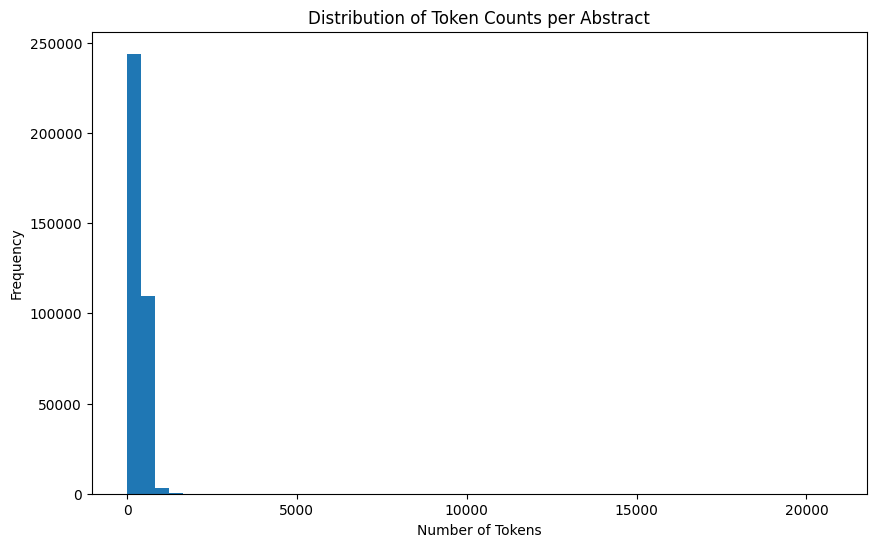

In [9]:
# Create a histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=50)
plt.title('Distribution of Token Counts per Abstract')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [15]:

# Check for missing abstracts
missing_abstracts = df['abstract'].isna()
print(f"\nNumber of missing abstracts: {missing_abstracts.sum()}")

if missing_abstracts.sum() > 0:
    print("\nRows with missing abstracts:")
    print(df[missing_abstracts][['doi', 'title']]) 



Number of missing abstracts: 5

Rows with missing abstracts:
                              doi  \
14795              10.1101/134171   
54167              10.1101/499178   
54168              10.1101/499178   
301253  10.1101/2023.12.21.572932   
302879  10.1101/2023.12.21.572932   

                                                    title  
14795   Smc6 And Top1 Prevent Aberrant Recombination A...  
54167   Competitive balance in the big five European l...  
54168   Competitive balance in the big five European l...  
301253  DNA-sequence and epigenomic determinants of lo...  
302879  DNA-sequence and epigenomic determinants of lo...  


In [17]:
# Drop rows with missing abstracts
df = df.dropna(subset=['abstract'])
print(f"\nDataset size after dropping missing abstracts: {len(df):,}")


Dataset size after dropping missing abstracts: 357,041


In [18]:
# Extract the abstracts as a list
abstracts = df['abstract'].tolist()

# Initialize a list to store embeddings
embeddings = []

# Define batch size
batch_size = 128

# Calculate total number of batches
total_batches = len(abstracts) // batch_size + (1 if len(abstracts) % batch_size != 0 else 0)

print(f"Processing {len(abstracts)} abstracts in {total_batches} batches...")

# Create a directory for periodic saves if it doesn't exist
save_dir = Path("../data/embedding_checkpoints")
save_dir.mkdir(exist_ok=True)

# Process in batches
for i in tqdm(range(0, len(abstracts), batch_size)):
    batch_end = min(i + batch_size, len(abstracts))
    batch = abstracts[i:batch_end]

    try:
        # Get embeddings for batch
        result = vo.embed(batch, model="voyage-3", input_type="document")

        # Append the embeddings to the list
        embeddings.extend(result.embeddings)

        # Small pause between batches to be nice to the API
        time.sleep(0.1)

    except Exception as e:
        print(f"Error processing batch starting at index {i}: {str(e)}")
        # Save partial progress in case of an error
        error_path = save_dir / f"embeddings_error_at_{i}.pkl"
        df['embedding'] = [None] * len(df)
        df.loc[:len(embeddings)-1, 'embedding'] = embeddings
        df.to_pickle(error_path)
        continue

# Assign the embeddings list to the DataFrame
df['embedding'] = embeddings

# Save final results
df.to_pickle('../data/biorxiv_with_embeddings.pkl')

# Verify embeddings
print("\nVerifying embeddings:")
print(f"Number of embeddings stored: {df['embedding'].notna().sum()}")
print(f"Shape of first embedding: {np.array(df['embedding'].iloc[0]).shape}")


Processing 357041 abstracts in 2790 batches...


100%|██████████| 2790/2790 [1:02:03<00:00,  1.33s/it] 
/var/folders/2t/mclktv0d6lg8d4nbwds0pc_c0000gn/T/ipykernel_27269/1186575570.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['embedding'] = embeddings



Verifying embeddings:
Number of embeddings stored: 357041
Shape of first embedding: (1024,)


In [19]:
df.head()

,doi,title,authors,author_corresponding,author_corresponding_institution,date,version,type,license,category,jatsxml,abstract,published,server,embedding
0,10.1101/000109,Speciation and introgression between Mimulus n...,Yaniv Brandvain;Amanda M Kenney;Lex Fagel;Grah...,Yaniv Brandvain,Department of Evolution and Ecology & Center f...,2013-11-07,1,New Results,cc_by,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Mimulus guttatus and M. nasutus are an evoluti...,10.1371/journal.pgen.1004410,biorxiv,"[0.0010087855625897646, -0.052346259355545044,..."
1,10.1101/000075,A Scalable Formulation for Engineering Combina...,Vanessa Jonsson;Anders Rantzer;Richard M Murray;,Vanessa Jonsson,Caltech,2013-11-07,1,New Results,cc_by_nc,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,It has been shown that optimal controller synt...,10.1109/ACC.2014.6859452,biorxiv,"[0.011138641275465488, -0.005674450192600489, ..."
2,10.1101/000240,Genome-wide targets of selection: female respo...,Paolo Innocenti;Ilona Flis;Edward H Morrow;,Edward H Morrow,University of Sussex,2013-11-12,1,New Results,cc_by,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Despite the common assumption that promiscuity...,NaN,biorxiv,"[-0.008628059178590775, -0.006960391532629728,..."
3,10.1101/000208,Population genomics of parallel hybrid zones i...,Nicola Nadeau;Mayte Ruiz;Patricio Salazar;Bria...,Chri Jiggins,Cambridge,2013-11-12,1,New Results,cc_by_nc_nd,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,Hybrid zones can be valuable tools for studyin...,10.1101/gr.169292.113,biorxiv,"[0.02453395538032055, -0.027050480246543884, 0..."
4,10.1101/000398,The Origin of Human-infecting Avian Influenza ...,Liangsheng Zhang;Zhenguo Zhang;,Zhenguo Zhang,"Department of Biology, The Pennsylvania State ...",2013-11-14,1,New Results,cc_by_nc_nd,Evolutionary Biology,https://www.biorxiv.org/content/early/2013/11/...,"In this study, we retraced the origin of the r...",NaN,biorxiv,"[0.030803075060248375, -0.03274550661444664, -..."
